In [1]:
import os
import sys

sys.path.append("../../")

import json
import pickle

import fasttreeshap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import GroupKFold

%reload_ext autoreload
%autoreload 2

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Train model: Cross-country 
This notebook is for re-producing the final model used to estimate wealth for the countries with no DHS ground truth.

We combine data from 4 countries where we have DHS ground truth (KH, MM, PH, TL) and train one combined model from all these data. 
The features and wealth indices are scaled per country to make them comparable. 

The output model is a Random Forest regressor trained on scaled labels (DHS Wealth Index) and features (area statistics for OSM, Ookla, and nighttime lights).

We evaluated the performance of the model via a leave-one-out cross-validation procedure in a separate notebook. Refer to our [doc site](https://thinkingmachines.github.io/unicef-ai4d-poverty-mapping/) for more details.


# Load Training Data

In [2]:
ROLLOUT_DATE = "-".join(os.getcwd().split("/")[-1].split("-")[:3])

# CSV file contains all data
# Metadata JSON file lists the feature columns and label column
data = pd.read_csv(f"{ROLLOUT_DATE}-training-data.csv")
with open(f"{ROLLOUT_DATE}-training-data-columns.json", "r") as file:
    column_metadata = json.load(file)

features = data[column_metadata["features"]]
labels = data[column_metadata["label"]]

# Cross-Validation

Note that the results here are different from our initial simulations ([see our docsite](https://thinkingmachines.github.io/unicef-ai4d-poverty-mapping/cross-country-report.html)). We switched to using MinMaxScaler instead of StandardScaler even though the latter provided higher overall R^2 values.

This is because in practice when we rolled out the models on actual nationwide data, we found that there was an overwhelming number of sparsely-populated, remote areas that had 0 values for the features. This pulled down the mean heavily for StandardScaler, falsely representing almost all areas with non-zero features as being "above-average", which also led most predictions to be > 0 / above-average. We found that utilizing MinMaxScaler was more stable in normalizing the range of feature values.

<generator object _BaseKFold.split at 0x7f4a235275f0>
Number of splits based on DHSCC unique values: 4
Split# 1
Train countries (num samples): {'MM', 'KH', 'TL'} (1507)
Test countries (num samples): {'PH'} (1213)
Split r^2: 0.36148169214316106 



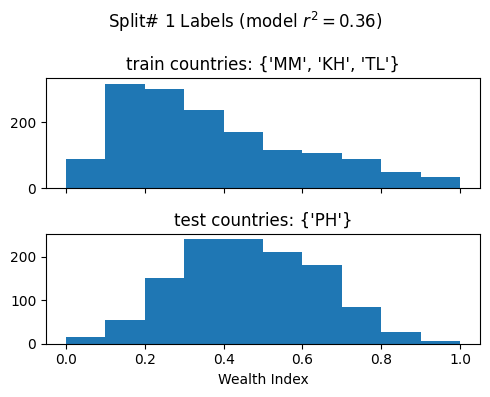

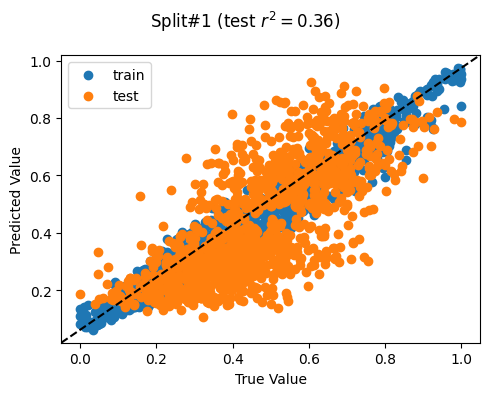

Split# 2
Train countries (num samples): {'PH', 'MM', 'TL'} (2109)
Test countries (num samples): {'KH'} (611)
Split r^2: 0.5332864418029645 



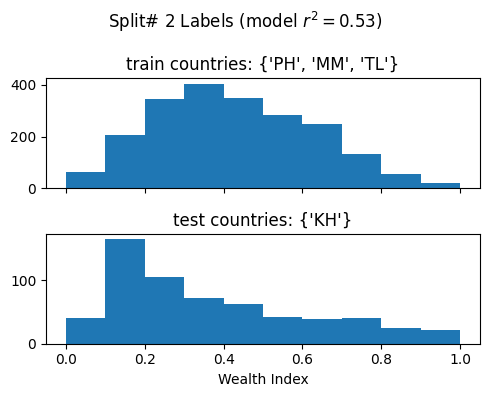

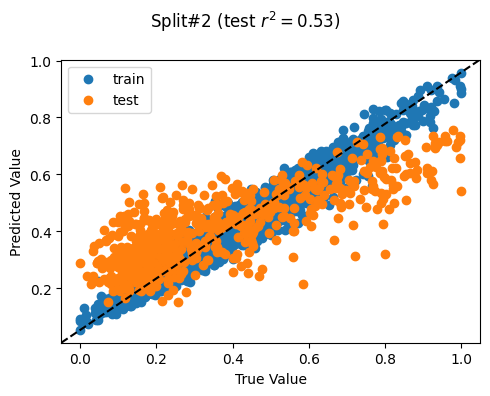

Split# 3
Train countries (num samples): {'PH', 'MM', 'KH'} (2265)
Test countries (num samples): {'TL'} (455)
Split r^2: 0.48714849847273733 



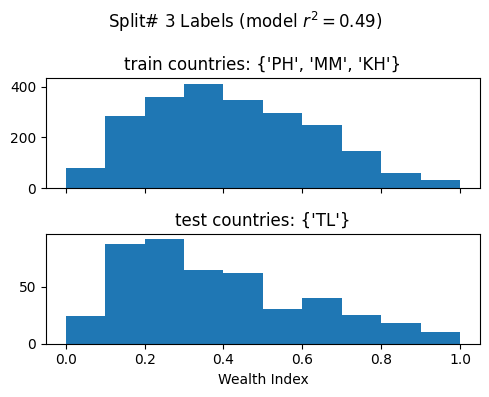

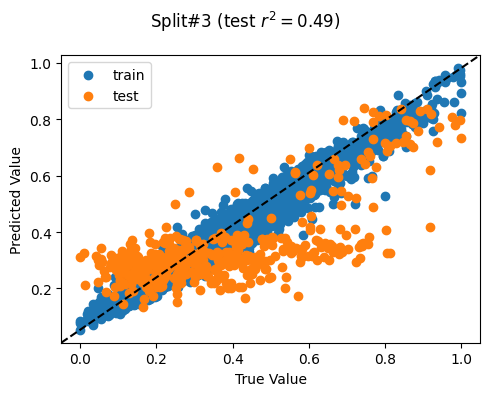

Split# 4
Train countries (num samples): {'PH', 'KH', 'TL'} (2279)
Test countries (num samples): {'MM'} (441)
Split r^2: 0.49303227606153877 



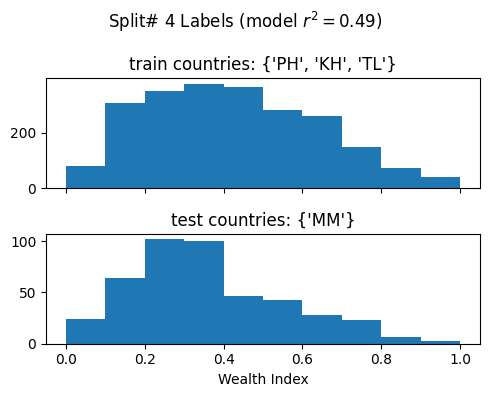

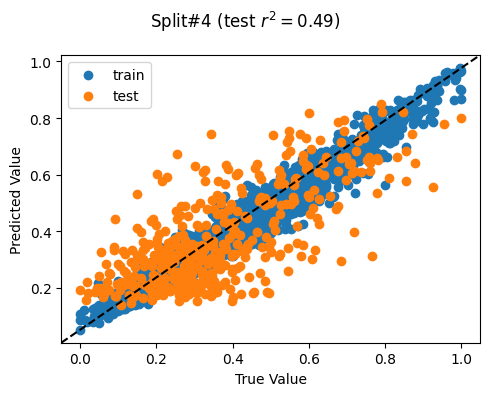

Mean split r^2  (std): 0.4687 (0.0644)


In [3]:
# Set parameters
groupkfold_col = "DHSCC"
random_seed = 42

# Prepare Folds - One per country
countries_data = pd.concat([data["DHSCC"], features, labels], axis=1)
groups = countries_data["DHSCC"].values
cv = GroupKFold(n_splits=len(set(groups)))
print(cv.split(features, groups=groups))
print(f"Number of splits based on DHSCC unique values: {cv.get_n_splits()}")


# Run  Leave One Out Cross Country Validation
model = RandomForestRegressor(n_estimators=100, random_state=random_seed, verbose=0)

split_r2_list = []

for i, (train, test) in enumerate(cv.split(features, labels, groups=groups)):
    print(f"Split# {i+1}")

    # Print info about current split
    train_labels = set(groups[train])
    test_labels = set(groups[test])
    print(f"Train countries (num samples): {train_labels} ({len(train)})")
    print(f"Test countries (num samples): {test_labels} ({len(test)})")

    # Split data into train/test
    X_train = features.values[train]
    X_test = features.values[test]
    y_train = labels.values.ravel()[train]
    y_test = labels.values.ravel()[test]

    # print('Input shapes (X_train, X_test, y_train, y_test): ',np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test))

    # Train model and get r2
    model.fit(X_train, y_train)
    split_r2 = r2_score(y_test, model.predict(X_test))
    split_r2_list.append(split_r2)
    print(f"Split r^2: {split_r2} \n")

    # Plot histogram of labels
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(5, 4))
    ax[0].hist(y_train)
    ax[0].set_title(f"train countries: {train_labels}")
    ax[1].hist(y_test)
    ax[1].set_title(f"test countries: {test_labels}")
    ax[1].set_xlabel("Wealth Index")
    fig.suptitle(f"Split# {i+1} Labels (model $r^2 = {round(split_r2,2)}$)")
    plt.tight_layout()
    plt.show()

    # Plot scatter plot
    fig, ax = plt.subplots(1, 1, figsize=(5, 4))
    ax.scatter(y_train, model.predict(X_train), label="train")
    ax.scatter(y_test, model.predict(X_test), label="test")
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle="dashed", color="k")
    ax.set_xlabel("True Value")
    ax.set_ylabel("Predicted Value")
    ax.legend()
    fig.suptitle(f"Split#{i+1} (test $r^2 = {round(split_r2,2)}$)")
    plt.tight_layout()
    plt.show()

split_r2_mean = round(np.array(split_r2_list).mean(), 4)
split_r2_std = round(np.array(split_r2_list).std(), 4)
print(f"Mean split r^2  (std): {split_r2_mean} ({split_r2_std})")

# Model Training

We evaluated the performance of the model via a leave-one-out cross-validation procedure in a separate notebook, so we will not repeat it here. Refer to our [doc site](https://thinkingmachines.github.io/unicef-ai4d-poverty-mapping/) for more details.



In [4]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=random_seed, verbose=0)
model.fit(features.values, labels.values.ravel())

RandomForestRegressor(random_state=42)

# SHAP Feature Importance

In [5]:
explainer = fasttreeshap.TreeExplainer(model)
shap_values = explainer.shap_values(features)

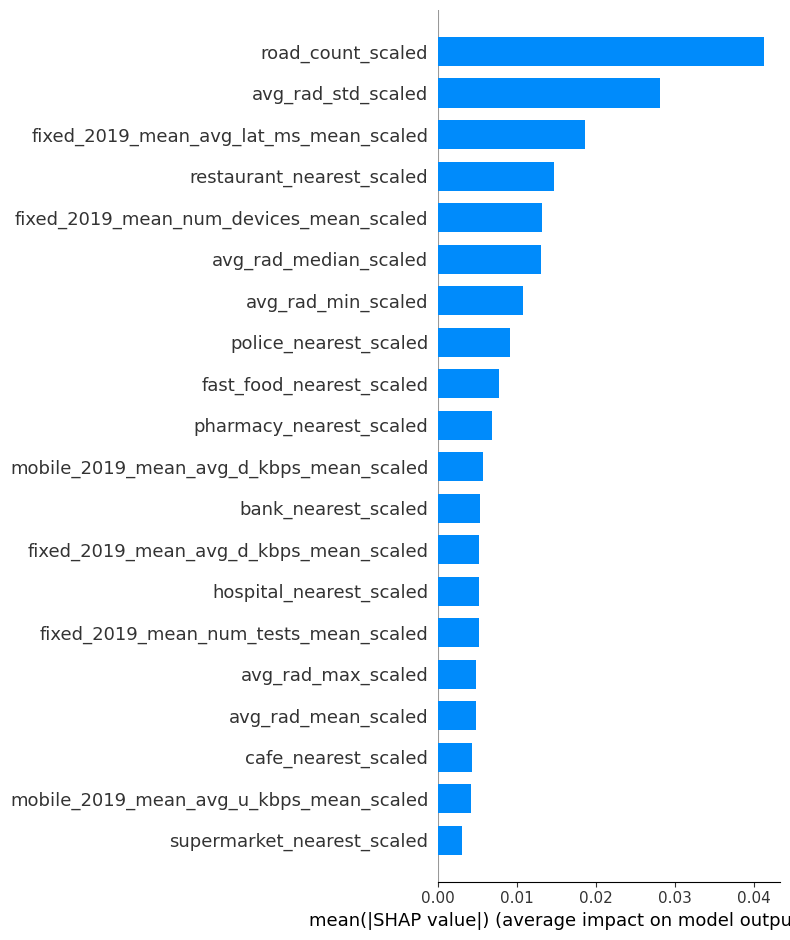

In [6]:
shap.summary_plot(
    shap_values, features, feature_names=features.columns, plot_type="bar"
)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


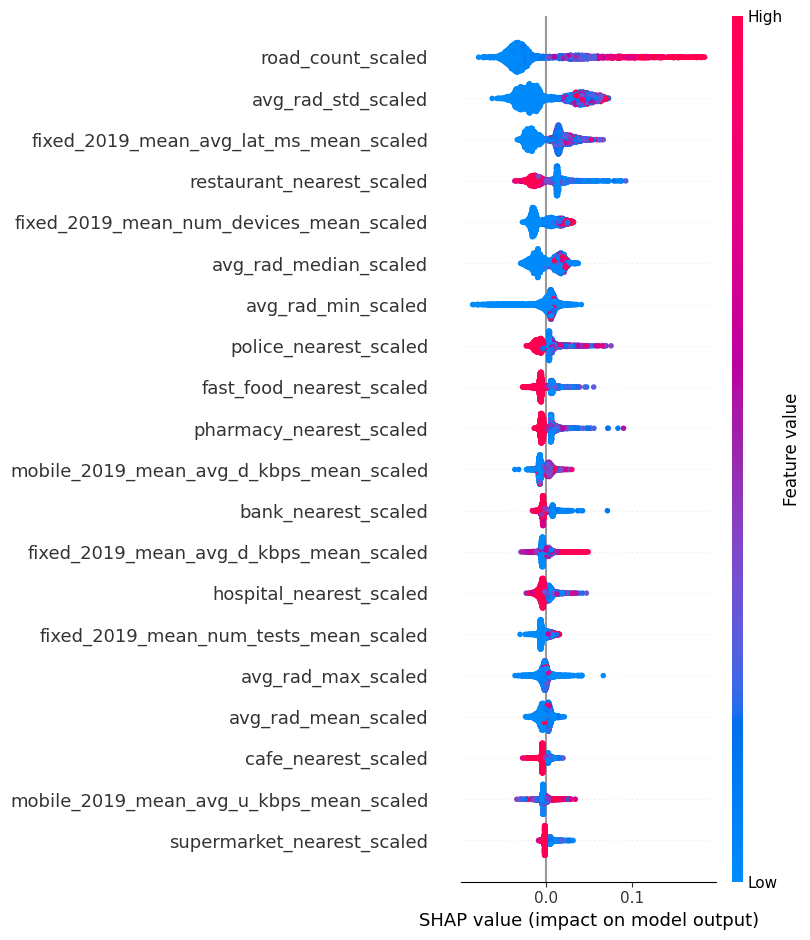

In [7]:
shap.summary_plot(shap_values, features.values, feature_names=features.columns)

## Save Model

In [8]:
model_save_path = f"./{ROLLOUT_DATE}-cross-country-model.pkl"
with open(model_save_path, "wb") as file:
    pickle.dump(model, file)